# Processing COVID AMP dataset for analysis and visualization

## Import

In [930]:
import pandas as pd
import numpy as np
from pyairtable import Table
from itertools import chain

import datetime as dt
import matplotlib
from matplotlib import font_manager
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as md
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas
import pycountry
import time
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_key = 'appoXaOlIgpiHK3I2'
table_name = 'Policy Database'

# AIRTABLE API KEY -- DON'T COMMIT INTO GIT!
api_key = 'MY_AIRTABLE_KEY'

In [89]:
table = Table(api_key, base_key, table_name)

records = table.all()

In [190]:
full = pd.DataFrame.from_records((r['fields'] for r in records))

## Cleaning

In [191]:
# remove non-policy guidance
full = full.loc[full['Policy/law type'] != 'Non-policy guidance']

In [192]:
# drop rows missing key information
full = full.dropna(subset=['Unique ID',
                           'Policy category', 
                           'Policy description', 
                           'Authorizing country ISO'])

In [193]:
# drop down to a select number of relevant columns
cols = ['Unique ID','Issued date','Effective start date','Anticipated end date','Actual end date','Policy category','Policy subcategory', 'Policy target','Policy relaxing or restricting','Authorizing country ISO','Auth state names (lookup)']
full = full[cols]

In [194]:
# convert to datetime for indexing
full['Issued date'] = pd.to_datetime(full['Issued date'], format='%Y/%m/%d')
full['Effective start date'] = pd.to_datetime(full['Effective start date'], format='%Y/%m/%d')
full['Anticipated end date'] = pd.to_datetime(full['Anticipated end date'], format='%Y/%m/%d')
full['Actual end date'] = pd.to_datetime(full['Actual end date'], format='%Y/%m/%d')

In [195]:
# rename geo columns 
full = full.rename(columns={'Auth state names (lookup)': 'State', 'Authorizing country ISO':'Country'})

In [196]:
# remove brackets from state and country name
full['State'] = full['State'].astype(str)
full['State'] = full['State'].str.extract("\'(.*)\'")

full['Country'] = full['Country'].astype(str)
full['Country'] = full['Country'].str.extract("\'(.*)\'")

In [165]:
full.to_csv('processed/airtable_cleaned_033123.csv')

### Cases

In [1456]:
# Load and transform cases CSV
global_cases = pd.read_csv('cases/time_series_covid19_confirmed_global.csv')
global_cases = global_cases.drop(columns=['Province/State','Lat','Long'])
global_cases.set_index('Country/Region', inplace=True)
global_cases = global_cases.reset_index().melt(id_vars='Country/Region', var_name='Date', value_name='Cases')

exclude = ['Diamond Princess','Winter Olympics 2022']
global_cases = global_cases.loc[~global_cases['Country/Region'].isin(exclude)]

In [1457]:
# To datetime
global_cases['Date']= pd.to_datetime(global_cases['Date'])

# Global-level
global_cases = global_cases.groupby(['Date']).sum().reset_index()

In [1464]:
global_cases['New cases'] = global_cases['Cases'].diff().fillna(0)

In [1467]:
global_cases['7-day rolling average new cases'] = global_cases['New cases'].rolling(window=7).mean().reset_index(0,drop=True)

In [1473]:
global_cases = global_cases.dropna()
global_cases['7-day rolling average new cases'] = global_cases['7-day rolling average new cases'].astype(int)

In [1474]:
global_cases.sort_values(by='7-day rolling average new cases')

,Date,Cases,New cases,7-day rolling average new cases
6,2020-01-28,5580,2651.0,717
34,2020-02-25,79721,854.0,729
7,2020-01-29,6169,589.0,801
35,2020-02-26,80679,958.0,806
33,2020-02-24,78867,568.0,864
...,...,...,...,...
737,2022-01-28,370610966,3678917.0,3351427
736,2022-01-27,366932049,3699709.0,3370170
735,2022-01-26,363232340,3761660.0,3375110
734,2022-01-25,359470680,3653799.0,3421056


In [1450]:
# global_cases['Cases'] = global_cases['Cases'].fillna(0)
# global_cases['Rolling average'] = global_cases['Cases'].rolling(window=7).mean().reset_index(0, drop=True)
# global_cases['Rolling average'] = global_cases['Rolling average'].fillna(0)
# global_cases['Rolling average'] = global_cases['Rolling average'].astype(int)

,Date,Cases
1138,2023-03-05,676023654
1139,2023-03-06,676081694
1140,2023-03-07,676212131
1141,2023-03-08,676391577
1142,2023-03-09,676568902


In [1452]:
# # Load and transform cases CSV
# global_cases = pd.read_csv('cases/time_series_covid19_confirmed_global.csv')
# global_cases = global_cases.drop(columns=['Province/State','Lat','Long'])
# global_cases = global_cases.groupby('Country/Region').sum().reset_index()

# # Calculate daily new cases
# global_cases.set_index('Country/Region', inplace=True)
# global_cases_diff = global_cases.diff(axis=1).fillna(global_cases.iloc[:,1:])
# global_cases_diff.columns = global_cases.columns
# global_cases_diff = global_cases_diff.reset_index().melt(id_vars='Country/Region', var_name='Date', value_name='New Cases')

# # Calculate 7-day rolling average
# global_cases_diff['Rolling_Average'] = global_cases_diff.groupby('Country/Region')['New Cases'].rolling(window=7).mean().reset_index(0, drop=True)
# global_cases_diff = global_cases_diff.reset_index(drop=True)

In [1397]:
us_cases = pd.read_csv('cases/time_series_covid19_confirmed_US.csv')
us_cases = us_cases.drop(columns=['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'])
us_cases.set_index('Province_State', inplace=True)
us_cases = us_cases.reset_index().melt(id_vars='Province_State', var_name='Date', value_name='Cases')

In [1398]:
us_cases['Date'] = pd.to_datetime(us_cases['Date'])
us_cases = us_cases.groupby(['Province_State', pd.Grouper(key='Date', freq='M')]).sum().reset_index()
us_cases['Date']= us_cases['Date']- pd.offsets.MonthBegin(1)

In [1399]:
us_cases.head()

,Province_State,Date,Cases
0,Alabama,2020-01-01,0
1,Alabama,2020-02-01,0
2,Alabama,2020-03-01,6735
3,Alabama,2020-04-01,127476
4,Alabama,2020-05-01,377501


## Visualizations

### Toolkit

In [405]:
clean = full.copy()

In [406]:
# Cut off for analysis
clean = clean.loc[clean['Effective start date'] > '2019-12-31'].reset_index(drop=True)
clean = clean.loc[clean['Effective start date'] < '2023-01-01'].reset_index(drop=True)


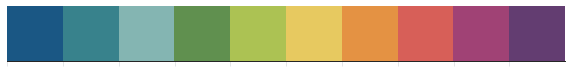

In [537]:
# Define rainbow color palette for categories
rainbow = {
    'Authorization and enforcement': '#1A5784',
    'Contact tracing/Testing': '#38828C',
    'Emergency declarations': '#84B5B2',
    'Enabling and relief measures':'#60904F',
    'Face mask':'#ACC253',
    'Military mobilization':'#E7C960',
    'Social distancing':'#E49243',
    'Support for public health and clinical capacity':'#D75F58',
    'Travel restrictions':'#A04275',
    'Vaccinations':'#633D71'
}

colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71']
sns.palplot(sns.color_palette(colors))



In [1046]:
# Define gradient color
gradient = ['#EEEFEF','#96CBD2','#147885']

cm = LinearSegmentedColormap.from_list(
        "Custom", gradient, N=100)

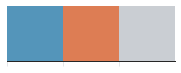

In [409]:
# Define small color palette for relaxing/restricting
three = ['#5495BA','#DD7D54','#CACED3']
sns.palplot(sns.color_palette(three))

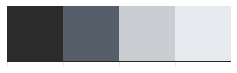

In [410]:
# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

In [717]:
# Define constants
figure_size = (18,6)

# Define x-axis range
left = dt.date(2019, 10, 1)
right = dt.date(2023, 1, 1)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.9

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 12

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = -35
plt.rcParams["ytick.minor.pad"] = -35
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 12


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

### Figure 1

#### 1B: Category distribution of policies by month, global

In [566]:
# Count all policies in a given category, by month
global_cat_count = clean.groupby(['Policy category', pd.Grouper(key='Effective start date', freq='M')]).size().reset_index(name="Policy count")

In [567]:
global_cat_count['Effective start date']= global_cat_count['Effective start date']- pd.offsets.MonthBegin(1)

In [568]:
global_cat_count_pivot = global_cat_count.pivot_table(index=pd.Grouper(key='Effective start date', freq='M'), columns='Policy category', values='Policy count', fill_value=0)
global_cat_count_pivot = global_cat_count_pivot.reset_index().rename_axis(None, axis=1)

In [569]:
global_cat_count_pivot['Effective start date']= global_cat_count_pivot['Effective start date']- pd.offsets.MonthBegin(1)

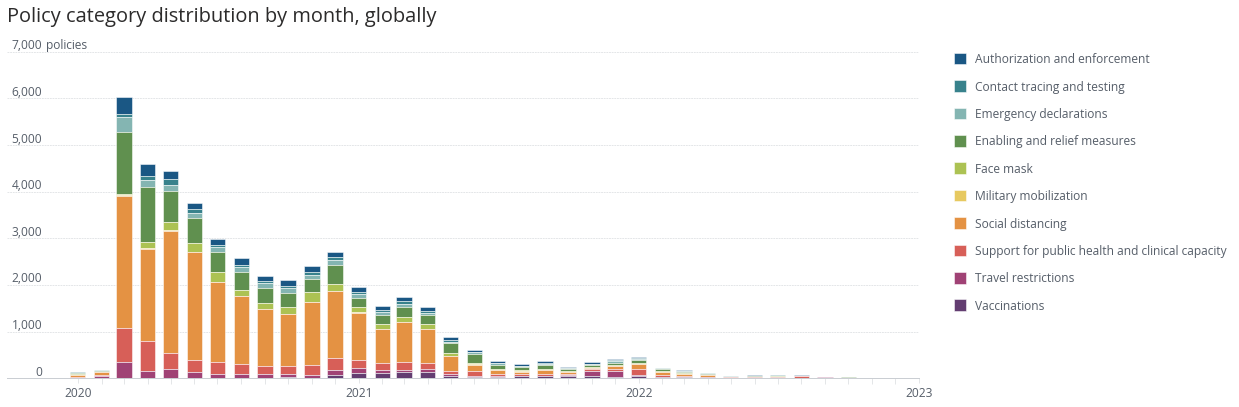

In [771]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')


# Define variables
x=global_cat_count_pivot['Effective start date']
y1=global_cat_count_pivot['Authorization and enforcement']
y2=global_cat_count_pivot['Contact tracing/Testing']
y3=global_cat_count_pivot['Emergency declarations']
y4=global_cat_count_pivot['Enabling and relief measures']
y5=global_cat_count_pivot['Face mask']
y6=global_cat_count_pivot['Military mobilization']
y7=global_cat_count_pivot['Social distancing']
y8=global_cat_count_pivot['Support for public health and clinical capacity']
y9= global_cat_count_pivot['Travel restrictions']
y10 = global_cat_count_pivot['Vaccinations']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom

plt.bar(x, y1, bottom=y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[0], label='Authorization and enforcement') 
plt.bar(x, y2, bottom=y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[1], label='Contact tracing and testing')
plt.bar(x, y3, bottom=y4+y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[2], label='Emergency declarations')
plt.bar(x, y4, bottom=y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[3], label='Enabling and relief measures')
plt.bar(x, y5, bottom=y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[4], label='Face mask')
plt.bar(x, y6, bottom=y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[5], label='Military mobilization')
plt.bar(x, y7, bottom=y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[6], label='Social distancing')
plt.bar(x, y8, bottom=y9+y10, linewidth=0.5,width=20, align="center", color=colors[7], label='Support for public health and clinical capacity')
plt.bar(x, y9, bottom=y10, linewidth=0.5,width=20, align="center", color=colors[8], label='Travel restrictions')
plt.bar(x, y10, bottom=0, linewidth=0.5, width=20, align="center", color=colors[9], label='Vaccinations')

ax.xaxis_date()

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,7000)

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax.xaxis.set_tick_params(which='minor', labelbottom=False)

# Set title
title = "Policy category distribution by month, globally"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)

# Format y-axis label
plt.ylabel("policies", rotation=0,loc='top',labelpad=-80,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")
    
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.35,1.03),labelcolor=chart[1],labelspacing=1.2)


plt.tight_layout()
plt.show()
# plt.savefig('figures/global_cat_per_month.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### 1D: Category distribution of policies by month, US

In [779]:
us_cat_count = clean.loc[clean['Country'] == 'USA'].reset_index(drop=True)

In [781]:
# Count all policies in a given category, by month
us_cat_count = us_cat_count.groupby(['Policy category', pd.Grouper(key='Effective start date', freq='M')]).size().reset_index(name="Policy count")

In [782]:
us_cat_count['Effective start date']= us_cat_count['Effective start date']- pd.offsets.MonthBegin(1)

In [783]:
us_cat_count_pivot = us_cat_count.pivot_table(index=pd.Grouper(key='Effective start date', freq='M'), columns='Policy category', values='Policy count', fill_value=0)
us_cat_count_pivot = us_cat_count_pivot.reset_index().rename_axis(None, axis=1)

In [784]:
us_cat_count_pivot['Effective start date']= us_cat_count_pivot['Effective start date']- pd.offsets.MonthBegin(1)

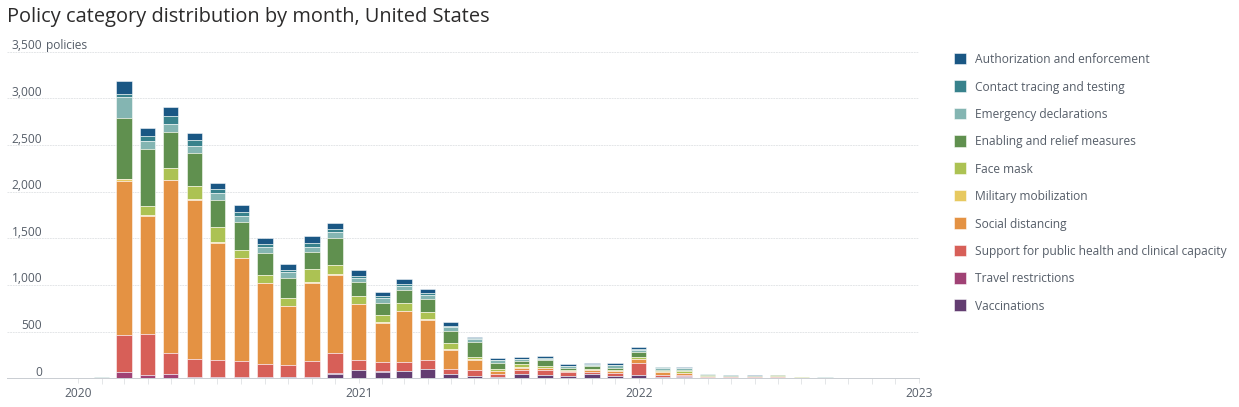

In [787]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')


# Define variables
x=us_cat_count_pivot['Effective start date']
y1=us_cat_count_pivot['Authorization and enforcement']
y2=us_cat_count_pivot['Contact tracing/Testing']
y3=us_cat_count_pivot['Emergency declarations']
y4=us_cat_count_pivot['Enabling and relief measures']
y5=us_cat_count_pivot['Face mask']
y6=us_cat_count_pivot['Military mobilization']
y7=us_cat_count_pivot['Social distancing']
y8=us_cat_count_pivot['Support for public health and clinical capacity']
y9= us_cat_count_pivot['Travel restrictions']
y10 = us_cat_count_pivot['Vaccinations']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom

plt.bar(x, y1, bottom=y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[0], label='Authorization and enforcement') 
plt.bar(x, y2, bottom=y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[1], label='Contact tracing and testing')
plt.bar(x, y3, bottom=y4+y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[2], label='Emergency declarations')
plt.bar(x, y4, bottom=y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[3], label='Enabling and relief measures')
plt.bar(x, y5, bottom=y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[4], label='Face mask')
plt.bar(x, y6, bottom=y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[5], label='Military mobilization')
plt.bar(x, y7, bottom=y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[6], label='Social distancing')
plt.bar(x, y8, bottom=y9+y10, linewidth=0.5,width=20, align="center", color=colors[7], label='Support for public health and clinical capacity')
plt.bar(x, y9, bottom=y10, linewidth=0.5,width=20, align="center", color=colors[8], label='Travel restrictions')
plt.bar(x, y10, bottom=0, linewidth=0.5, width=20, align="center", color=colors[9], label='Vaccinations')

ax.xaxis_date()

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,3500)

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax.xaxis.set_tick_params(which='minor', labelbottom=False)

# Set title
title = "Policy category distribution by month, United States"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)

# Format y-axis label
plt.ylabel("policies", rotation=0,loc='top',labelpad=-80,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")
    
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.35,1.03),labelcolor=chart[1],labelspacing=1.2)


plt.tight_layout()
# plt.show()
plt.savefig('figures/us_cat_per_month.svg', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

#### 1A: Total policies collected by country, globally

In [977]:
# Clean the clean df again
clean.loc[clean['Country'] == 'GB-ENG', 'Country'] = 'GBR'
clean.loc[clean['Country'] == 'GB-NIR', 'Country'] = 'GBR'
clean.loc[clean['Country'] == 'GB-SCT', 'Country'] = 'GBR'
clean.loc[clean['Country'] == 'GB-WLS', 'Country'] = 'GBR'
clean.loc[clean['Country'] == 'SXC', 'Country'] = 'KNA'

# Count all policies in a given country
global_count = clean.groupby(['Country']).size().reset_index(name="Policy count")

In [978]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.rename(columns={"iso_a3":"Country"})
cols = ['name','Country','geometry']
world = world[cols]
world = world.sort_values(by="Country")

In [979]:
# Fix issues in geopandas
world.loc[world['name'] == 'France', 'Country'] = 'FRA'
world.loc[world['name'] == 'Norway', 'Country'] = 'NOR'
world.loc[world['name'] == 'Somaliland', 'Country'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'Country'] = 'RKS'

In [980]:
# Add countries to geopandas
new_country = pd.DataFrame({'name': ['Aruba','American Samoa','Antigua and Barbuda','Bahrain','Curaçao','Cayman Islands','Hong Kong','Saint Kitts and Nevis','Macao','Maldives','Marshall Islands','Malta','Mauritius','Palau','Singapore','Seychelles','Tuvalu','Saint Vincent and the Grenadines','Samoa'], 
                            'Country': ['ABW','ASW','ATG','BHR','CUW','CYM','HKG','KNA','MAC','MDV','MHL','MLT','MUS','PLW','SGP','SYC','TUV','VCT','WSM']})
world = world.append(new_country, ignore_index=True)


In [981]:
merge = pd.merge(world,global_count,on='Country',how='outer')
merge['Policy count'] = merge['Policy count'].fillna(0)
merge['Policy count'] = merge['Policy count'].astype('int')
merge = merge[(merge.name != "Antarctica")]

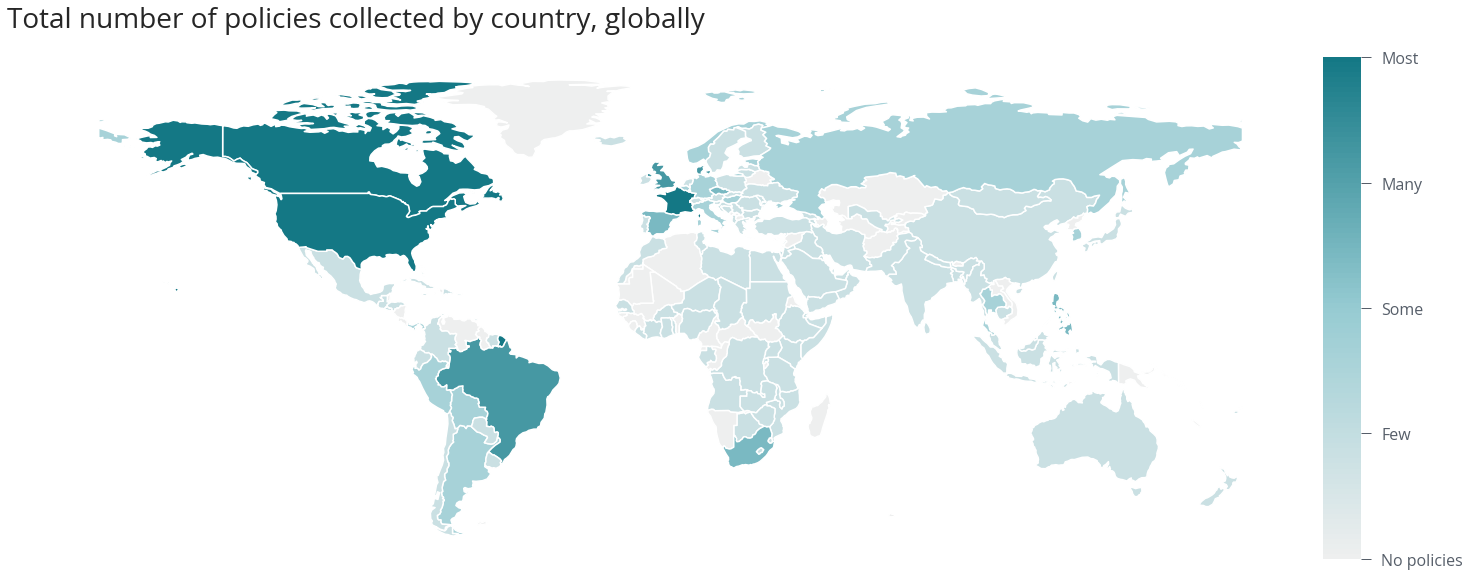

In [1143]:
# Set colorbar min and max values
vmin=merge['Policy count'].min()
vmax=merge['Policy count'].max()
vmid=((vmax+vmin)/2)
vq1=((vmin+vmid)/2)
vq3=((vmid+vmax)/2)

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(24, 18))

fig.subplots_adjust(hspace=0.0, wspace=0.0)

# Plot the map
merge.plot(column='Policy count',
           cmap=cm,
           scheme='User_Defined',
           legend=False,
           classification_kwds=dict(bins=[0,250,500,750,1000]),
           ax=ax
          )

# Adjust margins and set title
ax.margins(x=0.05) 

ttl = ax.set_title('Total number of policies collected by country, globally',fontsize=28)
ttl.set_position([0.25,1.05])

# Set the background color of the map
ax.set(facecolor='white')

# Turn axis off
ax.axis('off')

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cm,
                           norm=plt.Normalize(vmin=vmin,
                                              vmax=vmax))


sm._A = []
cbar = plt.colorbar(sm,cax=cax,drawedges=False)
cbar.set_ticks([vmin,vq1,vmid,vq3,vmax])
cbar.ax.yaxis.set_ticklabels(['No policies','Few','Some','Many','Most'])
cbar.ax.yaxis.set_tick_params(direction='out',length=10,width=1,pad=10,colors=chart[1],labelsize=16)
cbar.outline.set_visible(False)


# Display the map
plt.show()

# # Save
# plt.savefig('figures/total_global_policies.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### 1C: Total policies collected by state, United States

In [1186]:
# Filter to US, count policies by state
state_count = clean.loc[clean['Country']=='USA']
state_count = state_count.groupby(['State']).size().reset_index(name="Policy count")
# state_count = state_count.loc[(state_count["State"]!="Guam")&(state_count["State"]!="Puerto Rico")]

In [1187]:
usa = geopandas.read_file('spatial/states')

In [1188]:
usa = usa.rename(columns={"NAME":"State"})
cols = ['State','geometry']
usa = usa[cols]
usa = usa.sort_values(by="State")

In [1189]:
us_merge = pd.merge(usa,state_count,on='State',how='inner')
us_merge['Policy count'] = us_merge['Policy count'].fillna(0)
us_merge['Policy count'] = us_merge['Policy count'].astype('int')

In [1202]:
# Filter data for mainland and non-mainland territories
not_mainland = ['Alaska', 'Hawaii', "Puerto Rico","Guam"]
not_mainland = us_merge[us_merge['State'].isin(not_mainland)]
mainland = us_merge[~us_merge['State'].isin(not_mainland)]

hawaii = not_mainland.loc[(not_mainland["State"]=="Hawaii")]
alaska = not_mainland.loc[(not_mainland["State"]=="Alaska")]

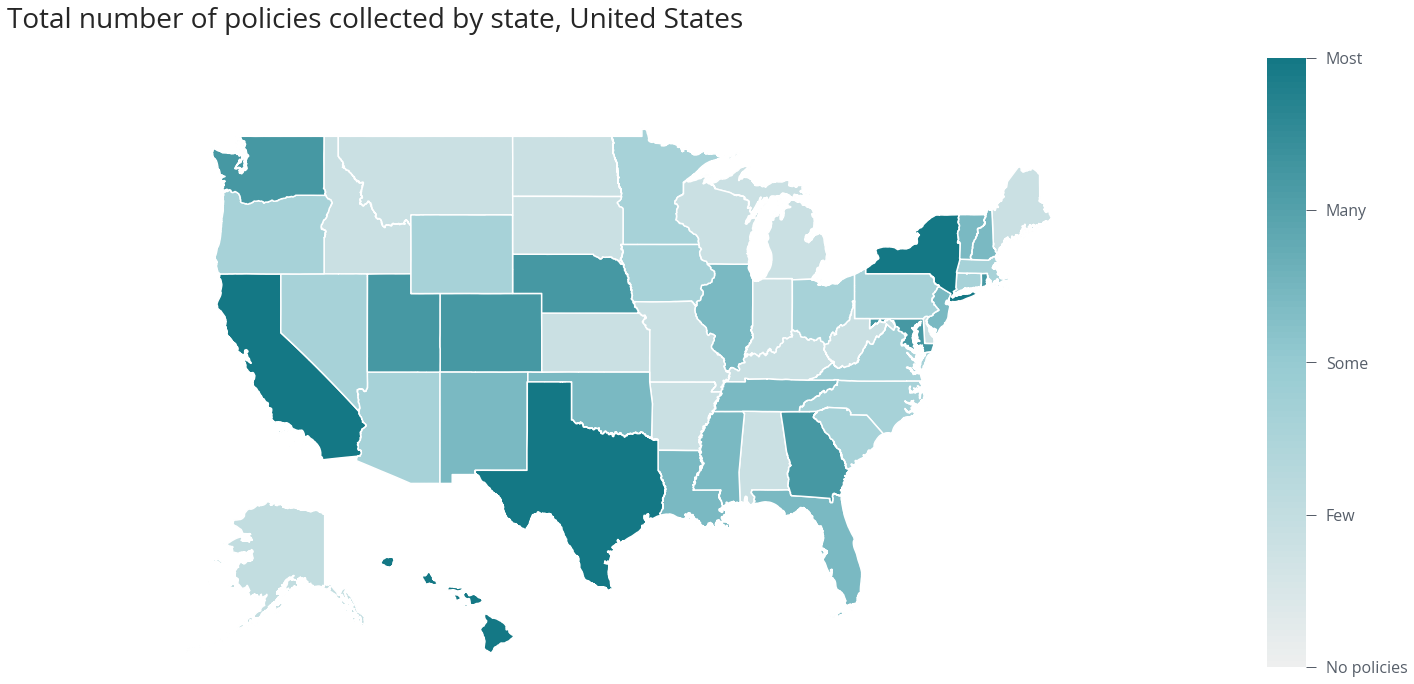

In [1218]:
# Set colorbar min and max values
vmin=0
vmax=us_merge['Policy count'].max()
vmid=((vmax+vmin)/2)
vq1=((vmin+vmid)/2)
vq3=((vmid+vmax)/2)

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(24, 18))

# Set bounds to fit desired areas in each plot
ax.set_xlim(-130, -64)
ax.set_ylim(22, 53)

fig.subplots_adjust(hspace=0.0, wspace=0.0)

# Plot the mainland map
mainland.plot(column='Policy count',
           cmap=cm,
           scheme='User_Defined',
           legend=False,
           classification_kwds=dict(bins=[0,250,500,750,1000]),
           ax=ax
          )

# Adjust margins and set title
ax.margins(x=0.05) 

ttl = ax.set_title('Total number of policies collected by state, United States',fontsize=28)
ttl.set_position([0.25,1.05])

# Set the background color of the map
ax.set(facecolor='white')

# Turn axis off
ax.axis('off')

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cm,
                           norm=plt.Normalize(vmin=vmin,
                                              vmax=vmax))


sm._A = []
cbar = plt.colorbar(sm,cax=cax,drawedges=False)
cbar.set_ticks([vmin,vq1,vmid,vq3,vmax])
cbar.ax.yaxis.set_ticklabels(['No policies','Few','Some','Many','Most'])
cbar.ax.yaxis.set_tick_params(direction='out',length=10,width=1,pad=10,colors=chart[1],labelsize=16)
cbar.outline.set_visible(False)

# Create an axis with 2 insets for Alaska and Hawaii
alaska_ax = ax.inset_axes([.05, .01, .20, .28])
hawaii_ax = ax.inset_axes([.25, .01, .15, .19])

alaska_ax.set_ylim(51, 72)
alaska_ax.set_xlim(-180, -127)

hawaii_ax.set_ylim(18.8, 22.5)
hawaii_ax.set_xlim(-160, -154.6)


# Plot Hawaii map
hawaii.plot(column='Policy count',
            cmap=cm,
            scheme='User_Defined',
            legend=False,
            classification_kwds=dict(bins=[0,250,500,750,1000]),
            ax=hawaii_ax)
hawaii_ax.margins(x=0.05)
hawaii_ax.set(facecolor='white')
hawaii_ax.axis('off')

# Plot Alaska map
alaska.plot(column='Policy count',
            cmap=cm,
            scheme='User_Defined',
            legend=False,
            classification_kwds=dict(bins=[0,250,500,750,1000]),
            ax=alaska_ax)
alaska_ax.margins(x=0.05)
alaska_ax.set(facecolor='white')
alaska_ax.axis('off')

# Display the map
plt.tight_layout()
plt.show()

# # Save
# plt.savefig('figures/total_us_policies.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Figure 2

#### 2A: Type of policy over time, compared to caseload, global

In [1250]:
# Count all policies of a given type, by month
global_type = clean.groupby(['Policy relaxing or restricting', pd.Grouper(key='Effective start date', freq='M')]).size().reset_index(name="Policy count")

# Calculate total policies by month
total_policies = global_type.groupby(pd.Grouper(key='Effective start date', freq='M'))['Policy count'].sum().reset_index(name='Total policies')

# Merge total_policies back into the original dataframe
global_type = pd.merge(global_type, total_policies, on='Effective start date')

# Calculate percent
global_type['Percent'] = (global_type['Policy count'] / global_type['Total policies'])


In [1251]:
global_type['Effective start date']= global_type['Effective start date']- pd.offsets.MonthBegin(1)

In [1252]:
global_type_pivot = global_type.pivot_table(index=pd.Grouper(key='Effective start date', freq='M'), columns='Policy relaxing or restricting', values='Percent', fill_value=0)
global_type_pivot = global_type_pivot.reset_index().rename_axis(None, axis=1)

In [1253]:
global_type_pivot['Effective start date']= global_type_pivot['Effective start date']- pd.offsets.MonthBegin(1)

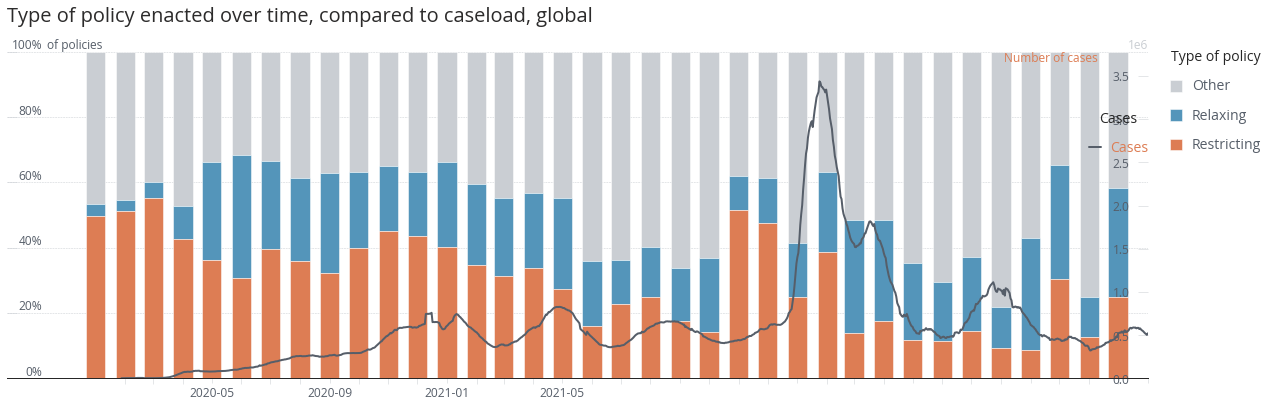

In [1476]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')


# Define variables
x=global_type_pivot['Effective start date']
y1 = global_type_pivot['Other']
y2 = global_type_pivot['Relaxing']
y3 = global_type_pivot['Restricting']


# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom

plt.bar(x, y1, bottom=y2+y3, linewidth=0.5, width=20, align="center", color=three[2], label='Other') 
plt.bar(x, y2, bottom=y3, linewidth=0.5, width=20, align="center", color=three[0], label='Relaxing')
plt.bar(x, y3, bottom=0, linewidth=0.5, width=20, align="center", color=three[1], label='Restricting')

ax.xaxis_date()

# Changes x-axis range
ax.set_xlim(left,right)

# Changes y-axis range
plt.gca().set_ybound(0,1)

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax.xaxis.set_tick_params(which='minor', labelbottom=False)

# Set title
title = "Type of policy enacted over time, compared to caseload, global"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)

# Format y-axis label
plt.ylabel("of policies", rotation=0,loc='top',labelpad=-95,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")
    
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in current_values])


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.01,1.04),labelcolor=chart[1],labelspacing=1.2)
leg.set_title('Type of policy')
leg.get_title().set_fontsize('14') 
plt.setp(plt.gca().get_legend().get_texts(), fontsize='14') 

# Create secondary y-axis
ax2 = ax.twinx()

# Plot line graph on secondary axis
x2 = global_cases['Date']
y4 = global_cases['7-day rolling average new cases']
ax2.plot(x2, y4, color=chart[1], linewidth=2.0, label='Cases')

# Set y-axis label for secondary axis
plt.ylabel("Number of cases", rotation=0, loc='top', labelpad=-50, color=three[1])

# Set y-axis range for secondary axis
ax2.set_ylim(0, max(y4)*1.1)

# Add legend for secondary axis
handles2, labels2 = ax2.get_legend_handles_labels()
leg2 = ax2.legend(handles=handles2, labels=labels2, bbox_to_anchor=(1.01, 0.85), labelcolor=three[1], labelspacing=1.2)
leg2.set_title('Cases')
leg2.get_title().set_fontsize('14')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='14') 

plt.tight_layout()
plt.show()


# plt.savefig('figures/global_cat_per_month.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')